<a href="https://colab.research.google.com/github/ahmedbouzid/Syteme-de-recomandation---texte-classification---arabe/blob/master/Sysreccontentbased.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importer les librairie necassaire

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
import re
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
citations = pd.read_excel('/content/citations.xlsx')


In [ ]:
citations.columns

Index(['Texte'], dtype='object')

In [ ]:
citations.head()

,Texte
0,هو محمد بن عبد الله بن عبد المطّلب بن هاشم بن ...
1,وهو من ولد إسماعيل بن إبراهيم عليه السلام وهو ...
2,وقد ربي عليه السلام بلا أب لأن أباه عبد الله ق...
3,اللهم صلى على سيدنا محمد وعلى آله محمد
4,اللَّهُمَّ صَلِّ عَلَى سَيِّدِنَا مُحَمَّدٍ وَ...


# Texte preprocessing - netoyage

Dans le traitement du langage naturel (NLP), la plupart du texte et des documents contiennent de nombreux mots redondants pour la classification du texte, tels que les mots vides, les fautes d'orthographe, les argots, etc. Dans cette section, nous expliquons brièvement certaines techniques et méthodes pour le texte. nettoyage et prétraitement des documents texte. Dans de nombreux algorithmes tels que les méthodes d'apprentissage statistiques et probabilistes, le bruit et les fonctionnalités inutiles peuvent affecter négativement les performances globales. Ainsi, l'élimination de ces caractéristiques est extrêmement importante.

In [ ]:
#supprimer les valeur null
citations.isnull().sum()
citations.dropna(how='any',inplace=True)

In [ ]:
#Supprimer les colonnes repeté
citations.duplicated().sum()
citations.drop_duplicates(inplace=True)

In [ ]:
#supprimer les extra caratéres
def remove_extra_char_from_words(text):
    text = ''.join(''.join(s)[:2] for _, s in itertools.groupby(text))
    return text
    citations["Texte"] = citations["Texte"].apply(lambda text: remove_extra_char_from_words(text))

In [ ]:
import string

In [ ]:
arabic_punctuations = '''ﷺ`÷×؛<>_()﴿﴾*&^%][ـ،/«:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuation= string.punctuation

In [ ]:
## Supprimer la ponctuation
PUNCT_TO_REMOVE = arabic_punctuations + english_punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))
citations["Texte"] = citations["Texte"].apply(lambda text: remove_punctuation(text))

In [ ]:
citations.sample(15)

,Texte
56,وَإِذَا سَأَلَكَ عِبَادِي عَنِّي فَإِنِّي قَرِ...
107,فَلاَ تَضْرِبُواْ لِلَّهِ ٱلأَمْثَالَ إِنَّ ٱل...
109,بِسمِ ٱلله الرَّحْمٰنِ الرَّحِيمِ ٱلْحَمْدُ...
73,ليس تقوى الله بصيام النهار ولا بقيام الليل وال...
103,ذٰلِكُمُ ٱللَّهُ رَبُّكُمْ لاۤ إِلَٰهَ إِلاَّ ...
30,قال الله تعالى وَاللَّهُ خَلَقَ كُلَّ دَابَّةٍ...
67,عنْ ابن عُمر رضي اللَّه عنهُما قَالَ نُهينَا ...
123,ٱللَّهُ ٱلصَّمَدُ
11,عنْ ابن عُمر رضي اللَّه عنهُما قَالَ نُهينَا ع...
6,صباح الخير


Supprimer les signes diacritiques

In [ ]:
arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)

In [ ]:
#fonction pour supprimer les mots diacritique
def remove_diacritics(text):
    text = re.sub(arabic_diacritics, '', text)
    return text
citations["Texte"]=citations["Texte"].apply(lambda text: remove_diacritics(text))

Normalisation de texte

In [ ]:
#fonction pour normaliser le texte
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text

In [ ]:
citations["Texte"]=citations["Texte"].apply(lambda text: normalize_arabic(text))

Supprimer les mots répetés

In [ ]:
#fonction pour supprimer les mots répéter
def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

In [ ]:
citations["Texte"]=citations["Texte"].apply(lambda text: remove_repeating_char(text))

In [ ]:
citations["Texte"].head(30)

0     هو محمد بن عبد اله بن عبد المطلب بن هاشم بن عب...
1     وهو من ولد اسماعيل بن ابراهيم عليه السلام وهو ...
2     وقد ربي عليه السلام بلا اب لان اباه عبد اله قد...
3                 الهم صلي علي سيدنا محمد وعلي اله محمد
4     الهم صل علي سيدنا محمد وازواجه وذريته كما صليت...
5     لهم بارك علي سيدنا محمد وعلي ال سيدنا محمد كما...
6                                            صباح الخير
7                                       اجمل صباح صباحك
8                                 صباح الشهد صباح العسل
9     صباح الخير يا اهل الخير جعل اله يومكم نور وبلغ...
10                          صباحكم من الجنه ايها الاحبه
11    عن ابن عمر رضي اله عنهما قال نهينا عن التكلف ر...
12    لا يعجبكم من الرجل طنطنته ولكن من ادي الامانه ...
13                                 عليك بالصدق وان قتلك
14                 اذا كان الشغل مجهده فان الفراغ مفسده
15           مكسبه فيها بعض الدناءه خير من مساءله الناس
16      علموا المهنه فانه يوشك ان يحتاج احدكم الي مهنته
17    عن ابي عمرو وقيل ابي عمره سفيان بن عبد اله

**Tokanization du texte**

La tokenisation est le processus consistant à décomposer un flux de texte en mots, phrases, symboles ou tout autre élément significatif appelé jetons. L'objectif principal de cette étape est d'extraire des mots individuels dans une phrase. Parallèlement à la classification de texte, dans le text mining, il est nécessaire d'incorporer un analyseur dans le pipeline qui effectue la tokenisation des documents



In [ ]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
#tokenize
def tokenize_text(text):
    tokens = nltk.word_tokenize(text)
    return tokens
citations["Texte"] = citations["Texte"].apply(lambda text:tokenize_text(text))

In [ ]:
citations["Texte"].head(20)

0     [هو, محمد, بن, عبد, اله, بن, عبد, المطلب, بن, ...
1     [وهو, من, ولد, اسماعيل, بن, ابراهيم, عليه, الس...
2     [وقد, ربي, عليه, السلام, بلا, اب, لان, اباه, ع...
3        [الهم, صلي, علي, سيدنا, محمد, وعلي, اله, محمد]
4     [الهم, صل, علي, سيدنا, محمد, وازواجه, وذريته, ...
5     [لهم, بارك, علي, سيدنا, محمد, وعلي, ال, سيدنا,...
6                                         [صباح, الخير]
7                                   [اجمل, صباح, صباحك]
8                            [صباح, الشهد, صباح, العسل]
9     [صباح, الخير, يا, اهل, الخير, جعل, اله, يومكم,...
10                    [صباحكم, من, الجنه, ايها, الاحبه]
11    [عن, ابن, عمر, رضي, اله, عنهما, قال, نهينا, عن...
12    [لا, يعجبكم, من, الرجل, طنطنته, ولكن, من, ادي,...
13                            [عليك, بالصدق, وان, قتلك]
14         [اذا, كان, الشغل, مجهده, فان, الفراغ, مفسده]
15    [مكسبه, فيها, بعض, الدناءه, خير, من, مساءله, ا...
16    [علموا, المهنه, فانه, يوشك, ان, يحتاج, احدكم, ...
17    [عن, ابي, عمرو, وقيل, ابي, عمره, سفيان, بن

Supprimer les StopWords

La classification des textes et des documents sur les réseaux sociaux, tels que Twitter, Facebook, etc. est généralement affectée par la nature bruyante (abréviations, formes irrégulières) des corpus de texte.

In [ ]:
pip install stop-words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32910 sha256=106e3fd314a332b0674d5050050c5b2f02676fd9c4979d5612d7a9feee9b13ec
  Stored in directory: /root/.cache/pip/wheels/eb/03/0d/3bd31c983789aeb0b4d5e2ca48590288d9db1586cf5f225062
Successfully built stop-words


In [ ]:
from stop_words import get_stop_words
get_stop_words('french')

In [ ]:
#fonction pour supprimer les stopWords
def remove_stopwords(text):
    stop_words = get_stop_words('arabic') +['عبد','اله','ال','ابن','ولكن','ابي','عنهما','علي','ايها','عنه','يا','لان','اباه','ايها','وعلي','فانه','وقيل','يقول','وعن','بعدما','الي','وله','شيء',' ا','ومن','وما','وهذا','وهذ','وهل','هذه','نه','من','لان','في','فمن','فما','ويا','لي','قل','قلت','ولد']
    token_list = []
    for word in text:
        if not word in stop_words:
            token_list.append(word)
    return token_list

In [ ]:
citations['Texte']=citations["Texte"].apply(lambda text: remove_stopwords(text))

In [ ]:
citations["Texte"].head(20)

0     [محمد, المطلب, هاشم, مناف, قصي, كلاب, مره, كعب...
1     [اسماعيل, ابراهيم, السلام, اسماعيل, ابراهيم, ا...
2     [ربي, السلام, بلا, اب, مات, حملت, امه, بشهرين,...
3                        [الهم, صلي, سيدنا, محمد, محمد]
4     [الهم, صل, سيدنا, محمد, وازواجه, وذريته, صليت,...
5     [لهم, بارك, سيدنا, محمد, سيدنا, محمد, باركت, س...
6                                               [الخير]
7                                         [اجمل, صباحك]
8                                        [الشهد, العسل]
9     [الخير, اهل, الخير, جعل, يومكم, نور, وبلغكم, ا...
10                              [صباحكم, الجنه, الاحبه]
11             [عمر, رضي, نهينا, التكلف, رواه, البخاري]
12    [يعجبكم, الرجل, طنطنته, ادي, الامانه, وكف, اعر...
13                                 [عليك, بالصدق, قتلك]
14                        [الشغل, مجهده, الفراغ, مفسده]
15                 [مكسبه, الدناءه, خير, مساءله, الناس]
16           [علموا, المهنه, يوشك, يحتاج, احدكم, مهنته]
17    [عمرو, عمره, سفيان, رضي, رسول, الاسلام, قو

In [ ]:
citations["Texte1"]=citations["Texte"]

In [ ]:
citations.head()

,Texte,Texte1
0,"[محمد, المطلب, هاشم, مناف, قصي, كلاب, مره, كعب...","[محمد, المطلب, هاشم, مناف, قصي, كلاب, مره, كعب..."
1,"[اسماعيل, ابراهيم, السلام, اسماعيل, ابراهيم, ا...","[اسماعيل, ابراهيم, السلام, اسماعيل, ابراهيم, ا..."
2,"[ربي, السلام, بلا, اب, مات, حملت, امه, بشهرين,...","[ربي, السلام, بلا, اب, مات, حملت, امه, بشهرين,..."
3,"[الهم, صلي, سيدنا, محمد, محمد]","[الهم, صلي, سيدنا, محمد, محمد]"
4,"[الهم, صل, سيدنا, محمد, وازواجه, وذريته, صليت,...","[الهم, صل, سيدنا, محمد, وازواجه, وذريته, صليت,..."


# **2/ Représentation des textes**

detokenazition de texte pour calculer TF-IDF

In [ ]:
citations['Texte']=citations['Texte'].astype(str)

In [ ]:
citations["Texte"]= citations['Texte'].str.replace(',', '')

In [ ]:
citations["Texte"]=citations['Texte'].str.replace("'", ' ')

In [ ]:
citations

,Texte
0,[ محمد المطلب هاشم مناف قصي كلاب م...
1,[ اسماعيل ابراهيم السلام اسماعيل ابراه...
2,[ ربي السلام بلا اب مات حملت امه ...
3,[ الهم صلي سيدنا محمد محمد ]
4,[ الهم صل سيدنا محمد وازواجه وذريته ...
...,...
133,[ عوضنا الم سكن جوفنا موقف ابكانا ...
134,[ الهم اني اسالك فارج الهم كاشف ال...
135,[ عباس رضي رسول الكرب العظيم الحليم ...
136,[ رسول صلي وسلم الكرب العظيم الحليم ...


Présentation avec TF - IDF

transformer les matrice tf-idf et appliqué le PCA

In [ ]:
#Importer TfIdfVectorizer de scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA as sklearnPCA
sklearn_pca = sklearnPCA(n_components=10000)
#Définir un objet vectoriseur TF-IDF
sklearn_pca = TfidfVectorizer()
pca_tfidf_sklearn = sklearn_pca.fit_transform(citations['Texte'])

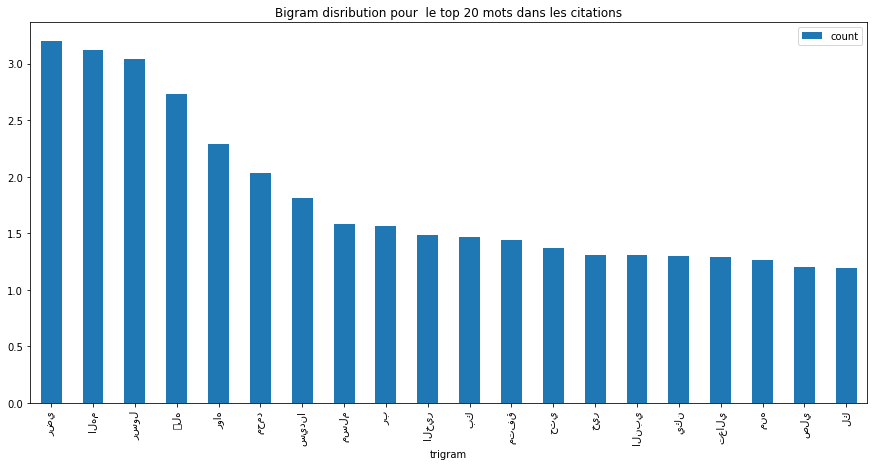

In [ ]:
total_words = pca_tfidf_sklearn.sum(axis=0)
#Trouver la fréquence des mots
freq = [(word, total_words[0, idx]) for word, idx in sklearn_pca.vocabulary_.items()]
freq =sorted(freq, key = lambda x: x[1], reverse=True)#conversion en dataframe
trigram = pd.DataFrame(freq)
trigram.rename(columns = {0:'trigram', 1: 'count'}, inplace = True)
#Prendre les 20 premiers citation
trigram = trigram.head(20)

#Plotting le trigramn  distribution
trigram.plot(x ='trigram', y='count', kind = 'bar', title = "Bigram disribution pour  le top 20 mots dans les citations", figsize = (15,7), )

le dimension de matrice TF-IDF

In [ ]:
pca_tfidf_sklearn.shape

(126, 1163)

afficher les feature_names

In [ ]:
sklearn_pca.get_feature_names()

['ءامن',
 'ءك',
 'ءكته',
 'اءتمن',
 'اب',
 'ابدا',
 'ابراهيم',
 'ابكانا',
 'ابناءك',
 'ابو',
 'ابواب',
 'ابوابا',
 'اتبعت',
 'اتق',
 'اتقي',
 'اتنا',
 'اتي',
 'اثقلكم',
 'اجرا',
 'اجمل',
 'اجيب',
 'احدا',
 'احدكم',
 'احدهم',
 'احرص',
 'احلامنا',
 'احمد',
 'اخاف',
 'اختياره',
 'اخصر',
 'اخلف',
 'ادرك',
 'ادميه',
 'ادي',
 'اذ',
 'اذن',
 'ارباح',
 'ارحم',
 'ارحمني',
 'اردت',
 'ارزقني',
 'ارسلناك',
 'اسال',
 'اسالك',
 'استخف',
 'استطاع',
 'استقم',
 'اسلم',
 'اسم',
 'اسماعيل',
 'اسمه',
 'اصابع',
 'اصابعه',
 'اصبح',
 'اصحاب',
 'اصروا',
 'اعتبر',
 'اعتق',
 'اعراض',
 'اعظم',
 'اعلي',
 'اعوذ',
 'اغنا',
 'افءدتهم',
 'افءده',
 'افتح',
 'افترض',
 'افسدتهم',
 'افلا',
 'اقلت',
 'اقوام',
 'اكرمت',
 'اكرمته',
 'اكفني',
 'اكل',
 'اكمل',
 'اكيس',
 'ال',
 'الءيم',
 'الا',
 'الاثنين',
 'الاجر',
 'الاجور',
 'الاحبه',
 'الاخر',
 'الاخره',
 'الاخرون',
 'الادله',
 'الاديان',
 'الاذي',
 'الاراء',
 'الارض',
 'الاستءذان',
 'الاستعداد',
 'الاسد',
 'الاسلام',
 'الاشعري',
 'الاشياء',
 'الاصدقاء',
 'الاعداء',
 'الاف

calculer le cosine_similarity

In [ ]:
# Calculer la matrice de similarité cosinus
cosine_sim = linear_kernel(pca_tfidf_sklearn, pca_tfidf_sklearn)

In [ ]:
cosine_sim.shape

(126, 126)

In [ ]:
cosine_sim[30]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.38014568,
       1.        , 0.06531191, 0.1851697 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.05857106, 0.        ,
       0.        , 0.10526477, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [ ]:
output1 = list(cosine_sim)

In [ ]:
print(output1)

[array([1.        , 0.        , 0.        , 0.18768835, 0.06653662,
       0.08898965, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.04641976, 0.        , 0.        , 0.05349808, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.    

Présentation avec CountVectorizer

transformer les vecteurs countVectorizer et appliqué PCA

In [ ]:
count_vectorizer = sklearnPCA(n_components=10000)

count_vectorizer = CountVectorizer()
cm=count_vectorizer.fit_transform((citations['Texte']))

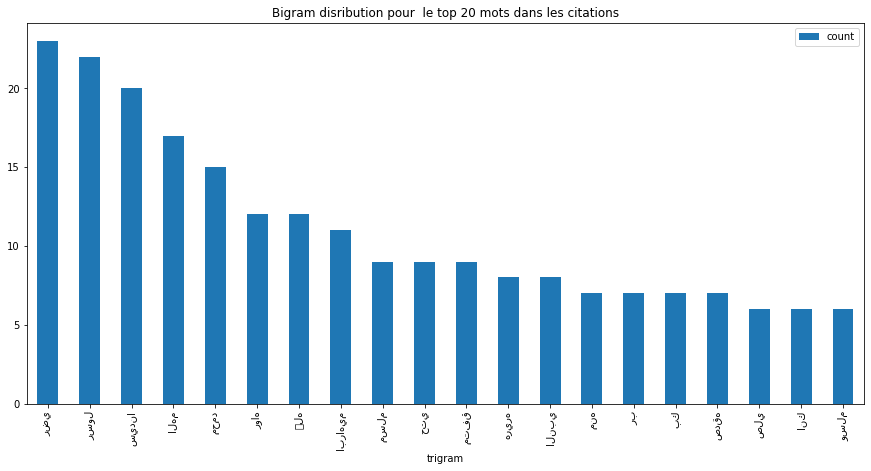

In [ ]:
total_words = cm.sum(axis=0)
#Trouver la fréquence des mots
freq = [(word, total_words[0, idx]) for word, idx in count_vectorizer.vocabulary_.items()]
freq =sorted(freq, key = lambda x: x[1], reverse=True)#convertion en dataframe
trigram = pd.DataFrame(freq)
trigram.rename(columns = {0:'trigram', 1: 'count'}, inplace = True)
#prendre les 20 premiers mots
trigram = trigram.head(20)

#Plotting le trigramn distribution
trigram.plot(x ='trigram', y='count', kind = 'bar', title = "Bigram disribution pour  le top 20 mots dans les citations", figsize = (15,7), )

afficher les feature_names

In [ ]:
print(count_vectorizer.get_feature_names())
print(cm.toarray())

['ءامن', 'ءك', 'ءكته', 'اءتمن', 'اب', 'ابدا', 'ابراهيم', 'ابكانا', 'ابناءك', 'ابو', 'ابواب', 'ابوابا', 'اتبعت', 'اتق', 'اتقي', 'اتنا', 'اتي', 'اثقلكم', 'اجرا', 'اجمل', 'اجيب', 'احدا', 'احدكم', 'احدهم', 'احرص', 'احلامنا', 'احمد', 'اخاف', 'اختياره', 'اخصر', 'اخلف', 'ادرك', 'ادميه', 'ادي', 'اذ', 'اذن', 'ارباح', 'ارحم', 'ارحمني', 'اردت', 'ارزقني', 'ارسلناك', 'اسال', 'اسالك', 'استخف', 'استطاع', 'استقم', 'اسلم', 'اسم', 'اسماعيل', 'اسمه', 'اصابع', 'اصابعه', 'اصبح', 'اصحاب', 'اصروا', 'اعتبر', 'اعتق', 'اعراض', 'اعظم', 'اعلي', 'اعوذ', 'اغنا', 'افءدتهم', 'افءده', 'افتح', 'افترض', 'افسدتهم', 'افلا', 'اقلت', 'اقوام', 'اكرمت', 'اكرمته', 'اكفني', 'اكل', 'اكمل', 'اكيس', 'ال', 'الءيم', 'الا', 'الاثنين', 'الاجر', 'الاجور', 'الاحبه', 'الاخر', 'الاخره', 'الاخرون', 'الادله', 'الاديان', 'الاذي', 'الاراء', 'الارض', 'الاستءذان', 'الاستعداد', 'الاسد', 'الاسلام', 'الاشعري', 'الاشياء', 'الاصدقاء', 'الاعداء', 'الافتات', 'الالمان', 'الامانه', 'الانسان', 'الاهوت', 'البخاري', 'البخل', 'البركه', 'البطاقه', 'البكاء', 

le dimension de matrice countvectorizer

In [ ]:
cm.shape

(126, 1163)

In [ ]:
print(cm[5])

  (0, 844)	8
  (0, 6)	7
  (0, 272)	2
  (0, 582)	15
  (0, 310)	1
  (0, 293)	4
  (0, 485)	4
  (0, 841)	3
  (0, 819)	1
  (0, 309)	1
  (0, 961)	1
  (0, 387)	1
  (0, 842)	1
  (0, 959)	1
  (0, 379)	1
  (0, 986)	1
  (0, 572)	1


calculer le cosine similarty

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
cos_similarity_countv =cosine_similarity(cm ,cm)

In [ ]:
cos_similarity_countv[30]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.41931393,
       1.        , 0.10101525, 0.25197632, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.0727393 , 0.        ,
       0.        , 0.13159034, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [ ]:
output2 = list(cos_similarity_countv)

In [ ]:
print(output2)

[array([1.        , 0.        , 0.        , 0.23904572, 0.1       ,
       0.12761265, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.0766965 , 0.        , 0.        , 0.08164966, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.    

# **3-Recommander Engine**

Utilisant KNN

In [ ]:
nbrs = NearestNeighbors(n_neighbors=20, algorithm='ball_tree').fit(output1)

In [ ]:
print(nbrs)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                 radius=1.0)


In [ ]:
distances, indices = nbrs.kneighbors(output1)

In [ ]:
distances

array([[0.        , 1.35577354, 1.36079709, ..., 1.43672037, 1.43672037,
        1.43672037],
       [0.        , 1.24370819, 1.43136782, ..., 1.4348217 , 1.4348217 ,
        1.43546912],
       [0.        , 1.24370819, 1.29305196, ..., 1.42361161, 1.42361161,
        1.42372433],
       ...,
       [0.        , 0.23238186, 1.4021541 , ..., 1.66748058, 1.670156  ,
        1.674932  ],
       [0.        , 0.23238186, 1.39236699, ..., 1.69281421, 1.69303821,
        1.6938367 ],
       [0.        , 1.32371165, 1.34852655, ..., 1.39626216, 1.39874145,
        1.41297816]])

In [ ]:
indices

array([[  0,  55, 125, ...,  21,   8,  80],
       [  1,   2,  82, ...,  95,   8,  55],
       [  2,   1,  82, ..., 108,  95,  54],
       ...,
       [123, 124,  20, ...,  88,  43,  92],
       [124, 123,  20, ...,  88,  17,  43],
       [125,  67,  53, ...,  49,  23,  87]])

In [ ]:
def get_index_from_Texte(texte):
    return citations[citations["Texte"]==texte].index.tolist()[0]

In [ ]:
all_citations_Texte= list(citations.Texte.values)

In [ ]:
all_citations_Texte

['[ محمد   المطلب   هاشم   مناف   قصي   كلاب   مره   كعب   لءي   غالب ]',
 '[ اسماعيل   ابراهيم   السلام   اسماعيل   ابراهيم   السلام   الفيل   اتي   ملك   الحبشه   لهدم   الكعبه ]',
 '[ ربي   السلام   بلا   اب   مات   حملت   امه   بشهرين   الصحيح   المواهب ]',
 '[ الهم   صلي   سيدنا   محمد   محمد ]',
 '[ الهم   صل   سيدنا   محمد   وازواجه   وذريته   صليت   سيدنا   ابراهيم   وبارك   سيدنا   محمد   وازواجه   وذريته   باركت   سيدنا   ابراهيم   انك   حميد   مجيد ]',
 '[ لهم   بارك   سيدنا   محمد   سيدنا   محمد   باركت   سيدنا   ابراهيم   انك   حميد   مجيد   الهم   وترحم   سيدنا   محمد   سيدنا   محمد   ترحمت   سيدنا   ابراهيم   سيدنا   ابراهيم   انك   حميد   مجيدالهم   وتحن   سيدنا   محمد   سيدنا   محمد   تحنت   سيدنا   ابراهيم   سيدنا   ابراهيم   انك   حميد   مجيد   الهم   وسلم   سيدنا   محمد   سيدنا   محمد   سلمت   سيدنا   ابراهيم   سيدنا   ابراهيم   انك   حميد   مجيد ]',
 '[ الخير ]',
 '[ اجمل   صباحك ]',
 '[ الشهد   العسل ]',
 '[ الخير   اهل   الخير   جعل   يومكم   نور   وبلغكم   الفرح

In [ ]:
def get_id_from_partial_genre(partial):
    for texte in all_citations_Texte:
        if partial in texte:
            print(texte,all_citations_Texte.index(texte))

In [ ]:
""" print_similar_query peut rechercher des citations similaires à la fois  par texte. """

def print_similar_citations(query=None,id=None):
    if id:
        for id in indices[id][1:]:
            print(citations.iloc[id]["Texte"])
    if query:
        found_id = get_index_from_Texte(query)
        for id in indices[found_id][1:]:
            print(citations.iloc[id]["Texte"])

In [ ]:
get_id_from_partial_genre("محمد")

[ محمد   المطلب   هاشم   مناف   قصي   كلاب   مره   كعب   لءي   غالب ] 0
[ الهم   صلي   سيدنا   محمد   محمد ] 3
[ الهم   صل   سيدنا   محمد   وازواجه   وذريته   صليت   سيدنا   ابراهيم   وبارك   سيدنا   محمد   وازواجه   وذريته   باركت   سيدنا   ابراهيم   انك   حميد   مجيد ] 4
[ لهم   بارك   سيدنا   محمد   سيدنا   محمد   باركت   سيدنا   ابراهيم   انك   حميد   مجيد   الهم   وترحم   سيدنا   محمد   سيدنا   محمد   ترحمت   سيدنا   ابراهيم   سيدنا   ابراهيم   انك   حميد   مجيدالهم   وتحن   سيدنا   محمد   سيدنا   محمد   تحنت   سيدنا   ابراهيم   سيدنا   ابراهيم   انك   حميد   مجيد   الهم   وسلم   سيدنا   محمد   سيدنا   محمد   سلمت   سيدنا   ابراهيم   سيدنا   ابراهيم   انك   حميد   مجيد ] 5
[ محمد   نبي   حقيقي   بمعني   الكلمه   يمكنا   انكار   محمدا   المرشد   القاءد   طريق   النجاه   دهانز   كونج   عالم   الاهوت   السويسري ] 55
[ محمدا   اعظم   عظماء   العالم   والدين   جاء   اكمل   الاديان   فارس   الخوري ] 56
[ بحثت   التاريخ   مثل   اعلي   لهذا   الانسان   فوجدته   النبي   العربي   محمد   صلي

In [ ]:
print_similar_citations(id=60 )

[ هريره   رضي   رسول   صلي   وسلم   قاربوا   وسدوا   واعلموا   ينجو   منكم   بعمله   قالوا   انت   رسول   انا   تغمدني   برحمه   منه   وفضل   رواه   مسلم ]
[ محمدا   اعظم   عظماء   العالم   والدين   جاء   اكمل   الاديان   فارس   الخوري ]
[ معاويه   رضي   سمعت   رسول   انك   اتبعت   عورات   المسلمين   افسدتهم   كدت   تفسدهم   حديث   صحيح ]
[ عباس   رضي   النبي   البركه   تنزل   وسط   الطعام   فكلوا   حافتيه   تاكلوا   وسطه   رواه   ابو   داود   والترمذي   حديث   حسن   صحيح ]
[ حفص   عمر   سلمه   الاسد   ربيب   رسول   كنت   غلاما   حجر   رسول   يدي   تطيش   الصحفه   فقال   رسول   غلام   سم   تعالي   وكل   بيمينك   وكل   يليك   »   زالت   تلك   طعمتي ]
[ بحثت   التاريخ   مثل   اعلي   لهذا   الانسان   فوجدته   النبي   العربي   محمد   صلي   وسلم   شاعر   الالمان   غوته ]
[ هريره   رضي   رسول   ليس   المسكين   ترده   التمره   والتمرتان   القمه   والقمتان   انما   المسكين   يتعف   »   متفق ]
[ ن   حكيم   حزام   رضي   النبي   اليد   العليا   خير   اليد   السفلي   وابدا   بمن   تعول   وخير   ال

2 éme methode **CountVectorizer**

In [ ]:
nbrs1 = NearestNeighbors(n_neighbors=20, algorithm='ball_tree').fit(output2)

In [ ]:
nbrs1

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                 radius=1.0)

In [ ]:
distances1, indices1 = nbrs.kneighbors(output2)

In [ ]:
distances1

array([[0.08360943, 1.3374826 , 1.34030273, ..., 1.45198722, 1.45198722,
        1.45198722],
       [0.02676185, 1.23749446, 1.43512552, ..., 1.43949697, 1.43949697,
        1.43949697],
       [0.01941448, 1.23475407, 1.28556031, ..., 1.42594998, 1.42594998,
        1.42606251],
       ...,
       [0.2930127 , 0.45849124, 1.43546804, ..., 1.64995053, 1.65913694,
        1.66216939],
       [0.16612101, 0.27928729, 1.37336426, ..., 1.66385626, 1.66593873,
        1.67140152],
       [0.0805923 , 1.3284554 , 1.33918509, ..., 1.39902855, 1.40036605,
        1.40085262]])

In [ ]:
indices1

array([[  0,   3,  55, ...,  25, 111,  21],
       [  1,   2,  82, ..., 111,   7,  79],
       [  2,   1,  82, ...,  80,  25,  54],
       ...,
       [123, 124,  20, ...,  61, 100,  44],
       [124, 123,  20, ...,  17,  43,  92],
       [125,  67,  73, ...,  56,  72,  87]])

In [ ]:

def print_similar_citations1(query=None,id=None):
    if id:
        for id in indices1[id][1:]:
            print(citations.iloc[id]["Texte"])
    if query:
        found_id = get_index_from_Texte(query)
        for id in indices1[found_id][1:]:
            print(citations.iloc[id]["Texte"])

In [ ]:
print_similar_citations1(id=60
                )

[ هريره   رضي   رسول   صلي   وسلم   قاربوا   وسدوا   واعلموا   ينجو   منكم   بعمله   قالوا   انت   رسول   انا   تغمدني   برحمه   منه   وفضل   رواه   مسلم ]
[ معاويه   رضي   سمعت   رسول   انك   اتبعت   عورات   المسلمين   افسدتهم   كدت   تفسدهم   حديث   صحيح ]
[ عباس   رضي   رسول   اكل   احدكم   طعاما   فلا   يمسح   اصابعه   حتي   يلعقها   يلعقها   متفق ]
[ هريره   رضي   رسول   ليس   المسكين   ترده   التمره   والتمرتان   القمه   والقمتان   انما   المسكين   يتعف   »   متفق ]
[ عباس   رضي   النبي   البركه   تنزل   وسط   الطعام   فكلوا   حافتيه   تاكلوا   وسطه   رواه   ابو   داود   والترمذي   حديث   حسن   صحيح ]
[ الرابع   هريره   رضي   النبي   يدخل   الجنه   اقوام   افءدتهم   مثل   افءده   الطير   رواه   مسلم   قيل   معناه   متوكلون   قلوبهم   رقيقه ]
[ حفص   عمر   سلمه   الاسد   ربيب   رسول   كنت   غلاما   حجر   رسول   يدي   تطيش   الصحفه   فقال   رسول   غلام   سم   تعالي   وكل   بيمينك   وكل   يليك   »   زالت   تلك   طعمتي ]
[ هريره   رضي   رسول   ايه   المنافق   ثلاث   حدث   كذب   واذا 

Présentation avec **Word2vect**

In [ ]:
#splitting le texte de citations

corpus = []
for words in citations['Texte']:
    corpus.append(words.split())

In [ ]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.models.phrases import Phrases, Phraser
import requests
from io import BytesIO
from nltk.tokenize import RegexpTokenizer


In [ ]:
# Downloading the Google pretrained Word2Vec Model
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'
google_word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

# Training our corpus with Google Pretrained Model

google_model = Word2Vec(size = 300, window=5, min_count = 2, workers = -1)
google_model.build_vocab(corpus)

#model.intersect_word2vec_format('./word2vec/GoogleNews-vectors-negative300.bin', lockf=1.0, binary=True)

google_model.intersect_word2vec_format(EMBEDDING_FILE, lockf=1.0, binary=True)

google_model.train(corpus, total_examples=google_model.corpus_count, epochs = 5)

--2021-08-09 17:45:19--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.105.69
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.105.69|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



(0, 0)

In [ ]:
google_model.wv.most_similar(positive=["رسول"])


[('الاراء', 0.15897414088249207),
 ('المسكين', 0.12398161739110947),
 ('الالمان', 0.10451953113079071),
 ('محمدا', 0.10302901268005371),
 ('الكريم', 0.10301455855369568),
 ('الخير', 0.10200518369674683),
 ('لانك', 0.10045099258422852),
 ('تقوي', 0.09933637827634811),
 ('البخاري', 0.0983269065618515),
 ('فاذا', 0.09625158458948135)]

In [ ]:
# Générer le word2vec average pour chaque texte de citation

def vectors(x):

    # Création d'une liste pour stocker les vecteurs (Texte en vecteurs)
    global word_embeddings
    word_embeddings = []

    # Lire le texte de chaque citation
    for line in citations['Texte']:
        avgword2vec = None
        count = 0
        for word in line.split():
            if word in google_model.wv.vocab:
                count += 1
                if avgword2vec is None:
                    avgword2vec = google_model[word]
                else:
                    avgword2vec = avgword2vec + google_model[word]

        if avgword2vec is not None:
            avgword2vec = avgword2vec / count

            word_embeddings.append(avgword2vec)

Building TF-IDF Word2Vec Model

In [ ]:
#Construire le modèle TFIDF et calculer le score TFIDF
from sklearn.decomposition import PCA as sklearnPCA
tfidf = sklearnPCA(n_components=10000)
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df = 5)
tfidf.fit(citations['Texte'])


# Obtenir les mots du modèle TF-IDF
tfidf_list = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))
tfidf_feature = tfidf.get_feature_names() # tfidf words/col-names

In [ ]:
tfidf_feature

['الناس',
 'النبي',
 'الهم',
 'اني',
 'بك',
 'تعالي',
 'حتي',
 'رب',
 'رسول',
 'رضي',
 'رضي النبي',
 'رضي رسول',
 'رواه',
 'رواه مسلم',
 'صلي',
 'صلي وسلم',
 'لك',
 'متفق',
 'محمد',
 'مسلم',
 'منه',
 'هريره',
 'هريره رضي',
 'وسلم',
 'ٱلذين',
 'ٱله']

In [ ]:
# Building TF-IDF Word2Vec

# Stockage des plongements TFIDF Word2Vec
tfidf_vectors = [];
line = 0;
# pour chaque texte de citation
for desc in corpus:
   #Les vecteurs de mots sont de longueur nulle (300 dimensions utilisées)
    sent_vec = np.zeros(300)
    # nombre de mots avec un vecteur valide dans la texte du citations
    weight_sum =0;
    # pour chaque mot dans la texte du citation
    for word in desc:
        if word in google_model.wv.vocab and word in tfidf_feature:
            vec = google_model.wv[word]
            tf_idf = tfidf_list[word] * (desc.count(word) / len(desc))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_vectors.append(sent_vec)
    line += 1

In [ ]:
#Recommandantion les 20 meilleurs citations similaires
def recommendations(title):

    # trouver le cosine similarity pour les vecteurs

    cosine_similarities = cosine_similarity(tfidf_vectors,  tfidf_vectors)

    # prendre le titre et le stocker dans un nouveau DataFrame appelé citation
    citation = citations[['Texte']]
    #Reverse mapping de l'index

    indices = pd.Series(citations.index, index = citations['Texte']).drop_duplicates()

    idx = indices[title]
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:20]
    citation_indices = [i[0] for i in sim_scores]
    return  citation.iloc[citation_indices]


In [ ]:
recommendations(20)

,Texte
135,[ عباس رضي رسول الكرب العظيم الحليم ...
136,[ رسول صلي وسلم الكرب العظيم الحليم ...
109,[ بسم ٱله الرحمٰن الرحيم ٱلحمد رب ...
51,[ ربكم ٱله ٱلذي خلق ٱلسمٰوٰت وٱلارض ...
30,[ تعالي واله خلق دابه ماء سوره الن...
32,[ تعالي خلق منالماء بشرا فجعله نسبا ...
31,[ تعالي اولم ير كفروا السماوات والار...
29,[ تعالي واله انزل السماء ماء فاحيا ...
74,[ ينبغي لرجل قاضيا حتي تكون خمس خص...
28,[ الماء اهم النعم انعم علينا لذلك ...
